In [42]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperModel
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Audio
import os
import glob

In [47]:
DEVICE = torch.device("mps")
DEVICE

device(type='mps')

## VoxConverse

- https://www.robots.ox.ac.uk/~vgg/data/voxconverse/index.html
- https://huggingface.co/datasets/diarizers-community/voxconverse

##

In [2]:
ds = load_dataset("diarizers-community/voxconverse")

README.md: 0.00B [00:00, ?B/s]

dev-00000-of-00005.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

dev-00001-of-00005.parquet:   0%|          | 0.00/449M [00:00<?, ?B/s]

dev-00002-of-00005.parquet:   0%|          | 0.00/492M [00:00<?, ?B/s]

dev-00003-of-00005.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

dev-00004-of-00005.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

test-00000-of-00011.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

test-00001-of-00011.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

test-00002-of-00011.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

test-00003-of-00011.parquet:   0%|          | 0.00/553M [00:00<?, ?B/s]

test-00004-of-00011.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

test-00005-of-00011.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

test-00006-of-00011.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

test-00007-of-00011.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

test-00008-of-00011.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

test-00009-of-00011.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

test-00010-of-00011.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/216 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/232 [00:00<?, ? examples/s]

In [8]:
ds

DatasetDict({
    dev: Dataset({
        features: ['audio', 'timestamps_start', 'timestamps_end', 'speakers'],
        num_rows: 216
    })
    test: Dataset({
        features: ['audio', 'timestamps_start', 'timestamps_end', 'speakers'],
        num_rows: 232
    })
})

In [20]:
first_row = ds['dev'][0]

In [21]:
duration = first_row['audio']['array'].shape[0] / first_row['audio']['sampling_rate']
print(f"Duration: {duration:.2f} sec")

Duration: 178.78 sec


In [22]:
display(Audio(first_row['audio']['array'], rate=first_row['audio']['sampling_rate']))

In [31]:
df_segments = pd.DataFrame(
    list(zip(first_row['timestamps_start'], first_row['timestamps_end'], first_row['speakers'])),
    columns=['Start', 'End', 'Speaker']
)
df_segments.sort_values('Start')

Start     End Speaker
9     0.16   34.00   spk03
0    34.72   42.36   spk00
10   42.40   66.20   spk03
2    65.56   96.24   spk02
12   68.28   68.92   spk03
11   80.72   81.24   spk00
16   96.24  100.20   spk00
3    98.04   98.76   spk02
19  100.28  123.24   spk01
4   113.84  115.00   spk02
5   123.24  127.04   spk02
13  127.04  145.60   spk03
6   145.76  152.72   spk02
20  152.44  154.44   spk01
17  153.32  154.48   spk00
7   154.52  163.36   spk02
14  163.32  167.04   spk03
21  167.04  173.72   spk01
8   173.76  174.44   spk02
18  174.40  175.24   spk00
22  175.12  175.60   spk01
15  175.40  178.12   spk03
1   178.12  178.76   spk01

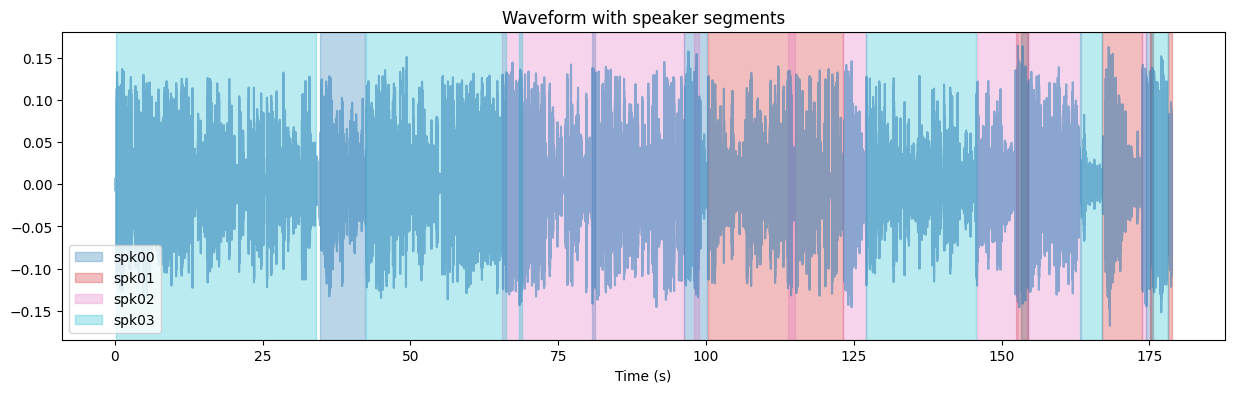

In [36]:
def show_audio_with_speakers(audio, sr, segments):
    plt.figure(figsize=(15, 4))
    times = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.plot(times, audio, alpha=0.5)

    # Draw speaker segments
    unique_speakers = segments['Speaker'].unique()
    colors = plt.get_cmap('tab10', len(unique_speakers))

    for i, spkr in enumerate(unique_speakers):
        for _, row in segments[segments['Speaker'] == spkr].iterrows():
            plt.axvspan(row['Start'], row['End'], color=colors(i), alpha=0.3, label=spkr)

    plt.xlabel("Time (s)")
    plt.title("Waveform with speaker segments")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

show_audio_with_speakers(first_row['audio']['array'], first_row['audio']['sampling_rate'], df_segments)

## RAVDESS

https://zenodo.org/records/1188976

In [40]:
audio_file = "/Users/anton/experiment_data/datasets/ravdess/Actor_01/03-01-01-01-01-01-01.wav"

In [41]:
display(Audio(audio_file))

## t-SNE visualization

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperModel.from_pretrained("openai/whisper-small")
model = model.eval().to(DEVICE)

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

In [ ]:
def get_hidden_states(audio, sr):
    inputs = processor(
        audio, sampling_rate=sr, return_tensors="pt"
    ).to(DEVICE)
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)
    # Shape: [batch, time, dim]
    states = out.encoder_hidden_states[-1][0]  # last layer
    return states.cpu().numpy()

In [49]:
def pool_embedding(states):
    return np.mean(states, axis=0)

In [57]:
sr = first_row['audio']['sampling_rate']
waveform = first_row['audio']['array']

speaker_embeddings = []
speaker_labels = []

for _, row in df_segments.iterrows():
    start = int(row['Start'] * sr)
    end = int(row['End'] * sr)
    chunk = waveform[start:end]
    if chunk.shape[0] < 1000:
        continue  # skip too short

    # Prepare input features for the encoder
    inputs = processor(chunk, sampling_rate=sr, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        encoder_out = model.encoder(**inputs)
    states = encoder_out.last_hidden_state[0].cpu().numpy()
    emb = pool_embedding(states)
    speaker_embeddings.append(emb)
    speaker_labels.append(row['Speaker'])

In [62]:
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    reduced = tsne.fit_transform(np.stack(embeddings))
    plt.figure(figsize=(8, 6))
    unique_labels = list(set(labels))
    colors = plt.get_cmap("tab10", len(unique_labels))
    for i, ul in enumerate(unique_labels):
        mask = [l == ul for l in labels]
        plt.scatter(reduced[mask, 0], reduced[mask, 1], label=ul, color=colors(i))
    plt.title(title)
    plt.legend()
    plt.show()

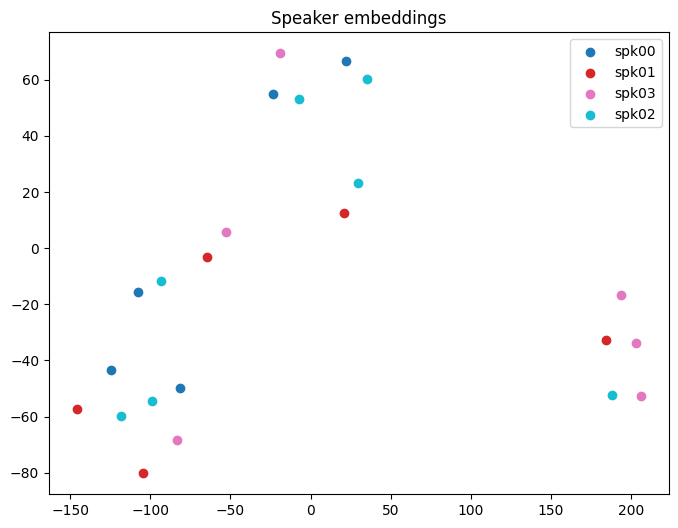

In [63]:
plot_tsne(speaker_embeddings, speaker_labels, "Speaker embeddings")

In [70]:
from tqdm.notebook import tqdm
import random

emotion_files = glob.glob("/Users/anton/experiment_data/datasets/ravdess/**/*.wav", recursive=True)
emotion_embeddings = []
emotion_labels = []

emotion_map = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

random.seed(42)
sampled_files = random.sample(emotion_files, 100)

for f in tqdm(sampled_files, desc="Extracting emotion embeddings"):
    waveform, sr = torchaudio.load(f)
    # If stereo, convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.squeeze().numpy()  # Convert to 1D numpy array
    # Whisper model expects audio sampled at 16000 Hz
    if sr != 16000:
        waveform = resampler(torch.tensor(waveform)).squeeze().numpy()
        sr = 16000

    inputs = processor(waveform, sampling_rate=sr, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        encoder_out = model.encoder(**inputs)
    states = encoder_out.last_hidden_state[0].cpu().numpy()
    emb = pool_embedding(states)
    code = int(os.path.basename(f).split("-")[2])
    label = emotion_map.get(code, "unknown")
    emotion_embeddings.append(emb)
    emotion_labels.append(label)

print(f"Extracted {len(emotion_embeddings)} emotion embeddings")

Extracting emotion embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Extracted 100 emotion embeddings


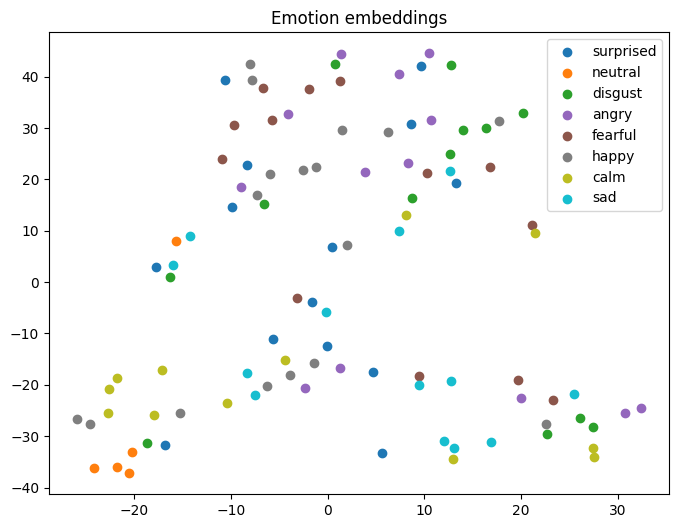

In [72]:
plot_tsne(emotion_embeddings, emotion_labels, "Emotion embeddings")